## Setup

Load libraries:

In [1]:
import sys
sys.path.append('..')

In [2]:
import pickle
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText

from utils.model_utils import evaluate_model
from utils.plotting_utils import plot_var, plot_results
from utils.validation_utils import validate_predictions
from sklearn.metrics import mean_squared_error, r2_score

## Load Data

* In-situ Data

In [76]:
insitu_data = pd.read_csv('../data/insitu_feb_08.csv')

insitu_data.info()
insitu_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1773 entries, 0 to 1772
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   easting              1773 non-null   float64
 1   northing             1773 non-null   float64
 2   observed_snow_depth  1773 non-null   float64
dtypes: float64(3)
memory usage: 41.7 KB


,easting,northing,observed_snow_depth
0,232262.0,4327196.0,1.10
1,232262.6,4327199.0,1.09
2,232263.3,4327202.1,1.09
3,232263.9,4327205.1,1.11
4,232264.5,4327208.1,1.18


* Predicted Snow Depth (XGBoost) and Lidar Snow Depth

In [4]:
xgboost_train_pred = pd.read_csv('../results/XGBoost/AllCombined/all/train_predictions.csv')
xgboost_train_pred.info()
xgboost_train_pred.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6008170 entries, 0 to 6008169
Data columns (total 1 columns):
 #   Column           Dtype  
---  ------           -----  
 0   snow_depth_pred  float64
dtypes: float64(1)
memory usage: 45.8 MB


,snow_depth_pred
0,0.799301
1,1.188395
2,0.813393
3,1.067113
4,0.602620


In [5]:
xgboost_test_pred = pd.read_csv('../results/XGBoost/AllCombined/all/test_predictions.csv')
xgboost_test_pred.info()
xgboost_test_pred.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667575 entries, 0 to 667574
Data columns (total 1 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   snow_depth_pred  667575 non-null  float64
dtypes: float64(1)
memory usage: 5.1 MB


,snow_depth_pred
0,1.235192
1,0.801494
2,1.015072
3,1.029879
4,0.956967


In [6]:
with open('../data/full_splits.pkl', 'rb') as f:
    full_splits = pickle.load(f)

In [7]:
all_test_pred=(
    full_splits['X_test'][['idx','easting', 'northing']]
    .reset_index(drop=True)
    .assign(
        snow_depth=full_splits['y_test'].reset_index(drop=True),
        snow_depth_pred=xgboost_test_pred['snow_depth_pred']
    )
)

all_test_pred.loc[all_test_pred.snow_depth_pred < 0, 'snow_depth_pred'] = 0

all_train_pred=(
    full_splits['X_temp'][['idx','easting', 'northing']]
    .reset_index(drop=True)
    .assign(
        snow_depth=full_splits['y_temp'].reset_index(drop=True),
        snow_depth_pred=xgboost_train_pred['snow_depth_pred']
    )
)

all_train_pred.loc[all_train_pred.snow_depth_pred < 0, 'snow_depth_pred'] = 0

xgboost_pred=pd.concat([all_train_pred, all_test_pred], axis=0)
xgboost_pred.head()

,idx,easting,northing,snow_depth,snow_depth_pred
0,7421518,226779.680055,4.328681e+06,0.796555,0.799301
1,2084927,225405.569684,4.323877e+06,1.178391,1.188395
2,6339864,221493.255442,4.327709e+06,0.814377,0.813393
3,3731247,224859.525825,4.325359e+06,1.059983,1.067113
4,14343,223032.379067,4.322014e+06,0.609543,0.602620


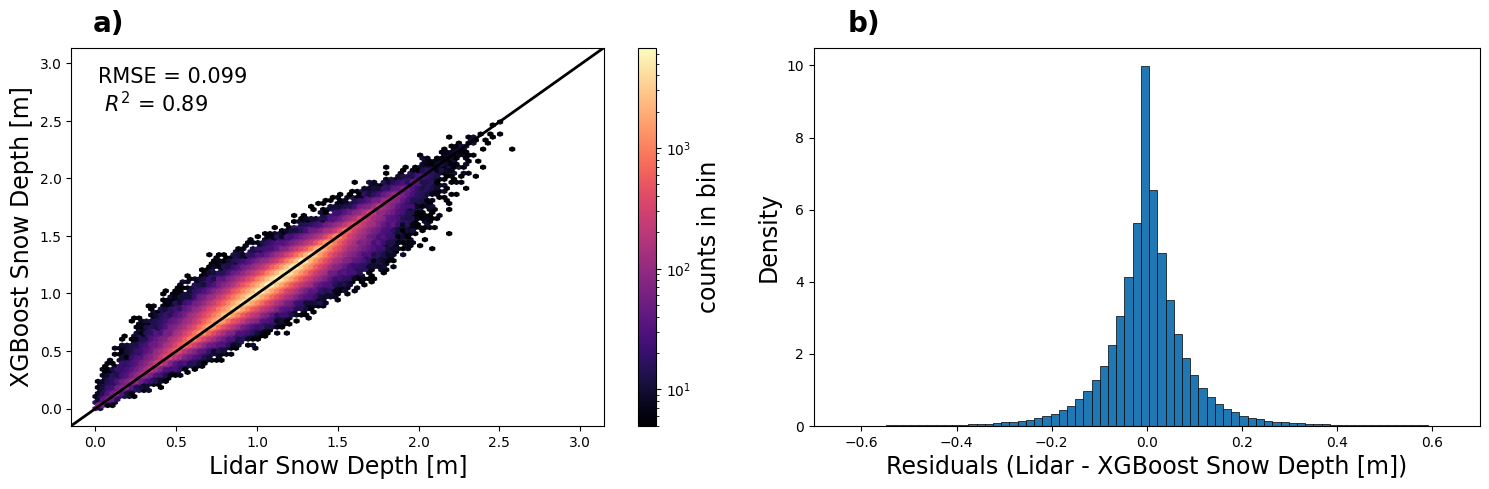

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

hb = ax[0].hexbin(all_test_pred.snow_depth, all_test_pred.snow_depth_pred, gridsize=100, cmap='magma', bins='log', mincnt=5)
# ax[0].axis('equal')
ax[0].plot([0,1], [0,1], transform=ax[0].transAxes, color='black', lw=2)
ax[0].set_xlabel('Lidar Snow Depth [m]', fontsize=17)
ax[0].set_ylabel('XGBoost Snow Depth [m]', fontsize=17)
cb = plt.colorbar(hb)
cb.set_label('counts in bin', fontsize=17)
# Add RMSE and R² annotations
ax[0].text(0.05, 0.95, f'RMSE = {0.099} \n $R^2$ = {0.89}', transform=ax[0].transAxes, fontsize=15, verticalalignment='top')
ax[0].text(0.1, 1.1, 'a)', transform=ax[0].transAxes, fontsize=20, fontweight='bold', va='top', ha='right')


depth_diff=all_test_pred.snow_depth - all_test_pred.snow_depth_pred
ax[1].hist(depth_diff, bins=250, density=True, edgecolor='black', linewidth=0.5)
ax[1].set_xlim(-0.7, 0.7)
ax[1].set_ylabel('Density', fontsize=17)
ax[1].set_xlabel('Residuals (Lidar - XGBoost Snow Depth [m])', fontsize=17)
# ax[1].axvline(0, color='k', linestyle='--')
ax[1].text(0.1, 1.1, 'b)', transform=ax[1].transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.savefig('../plots/ASO_vs_XGBoost.png', dpi=300)
plt.show()

## Get Model Performace without training models in open and vegetated areas

In [12]:
all_pred_for_seg=(
    full_splits['X_test'][['vegetation_ht']]
    .reset_index(drop=True)
    .assign(
        snow_depth=full_splits['y_test'].reset_index(drop=True),
        snow_depth_pred=xgboost_test_pred['snow_depth_pred']
    )
)

all_pred_for_seg.head()

,vegetation_ht,snow_depth,snow_depth_pred
0,1.748535,1.270676,1.235192
1,0.000000,0.799973,0.801494
2,0.000000,1.053391,1.015072
3,8.635010,1.089524,1.029879
4,0.117920,1.071701,0.956967


In [13]:
vegetation_preds = all_pred_for_seg[all_pred_for_seg.vegetation_ht >= 0.5]
no_vegetation_preds = all_pred_for_seg[all_pred_for_seg.vegetation_ht < 0.5]

veg_evals=evaluate_model(y_true=vegetation_preds.snow_depth, y_pred=vegetation_preds.snow_depth_pred, model_name="XGB Vegetation")
noveg_evals=evaluate_model(y_true=no_vegetation_preds.snow_depth, y_pred=no_vegetation_preds.snow_depth_pred, model_name="XGB No Vegetation")
combined_evals=evaluate_model(y_true=all_pred_for_seg.snow_depth, y_pred=all_pred_for_seg.snow_depth_pred, model_name="XGB Combined")

pd.concat([veg_evals, noveg_evals, combined_evals], axis=1)

,XGB Vegetation,XGB No Vegetation,XGB Combined
RMSE,0.104083,0.094993,0.098777
MBE,0.000317,-0.000086,0.000078
RSQ,0.857839,0.901498,0.886328


## Validation

In [14]:
insitu_vs_xgboost=validate_predictions(
    predictions=xgboost_pred,
    ground_truth=insitu_data,
    pred_col='snow_depth_pred',
    gt_col='observed_snow_depth',
    buffer_distance=3
)

insitu_vs_lidar=validate_predictions(
    predictions=xgboost_pred,
    ground_truth=insitu_data,
    pred_col='snow_depth',
    gt_col='observed_snow_depth',
    buffer_distance=3
)

insitu_vs_xgboost_test=validate_predictions(
    predictions=all_test_pred,
    ground_truth=insitu_data,
    pred_col='snow_depth_pred',
    gt_col='observed_snow_depth',
    buffer_distance=3
)

In [15]:
lidar_insitu_rmse=mean_squared_error(
    y_true=insitu_vs_lidar['observed_snow_depth'],
    y_pred=insitu_vs_lidar['snow_depth'],
    squared=False
)

lidar_insitu_r2=r2_score(
    y_true=insitu_vs_lidar['observed_snow_depth'],
    y_pred=insitu_vs_lidar['snow_depth']
)

xgboost_insitu_rmse=mean_squared_error(
    y_true=insitu_vs_xgboost['observed_snow_depth'],
    y_pred=insitu_vs_xgboost['snow_depth_pred'],
    squared=False
)

xgboost_insitu_r2=r2_score(
    y_true=insitu_vs_xgboost['observed_snow_depth'],
    y_pred=insitu_vs_xgboost['snow_depth_pred']
)

xgboost_test_insitu_rmse=mean_squared_error(
    y_true=insitu_vs_xgboost_test['observed_snow_depth'],
    y_pred=insitu_vs_xgboost_test['snow_depth_pred'],
    squared=False
)

xgboost_test_insitu_r2=r2_score(
    y_true=insitu_vs_xgboost_test['observed_snow_depth'],
    y_pred=insitu_vs_xgboost_test['snow_depth_pred']
)

print("RMSE:")
print("=====")
print(f'Lidar vs insitu data: {lidar_insitu_rmse*100:.3f} [cm]')
print(f'XGBoost vs insitu data: {xgboost_insitu_rmse*100:.3f} [cm]')
print(f'XGBoost (test) vs insitu : {xgboost_test_insitu_rmse*100:.3f} [cm]')

print("")
print("R^2:")
print("===")
print(f'Lidar vs insitu data: {lidar_insitu_r2:.3f}')
print(f'XGBoost vs insitu data: {xgboost_insitu_r2:.3f}')
print(f'XGBoost (test) vs insitu : {xgboost_test_insitu_r2:.3f}')

RMSE:
=====
Lidar vs insitu data: 15.853 [cm]
XGBoost vs insitu data: 15.903 [cm]
XGBoost (test) vs insitu : 18.110 [cm]

R^2:
===
Lidar vs insitu data: 0.332
XGBoost vs insitu data: 0.328
XGBoost (test) vs insitu : 0.196


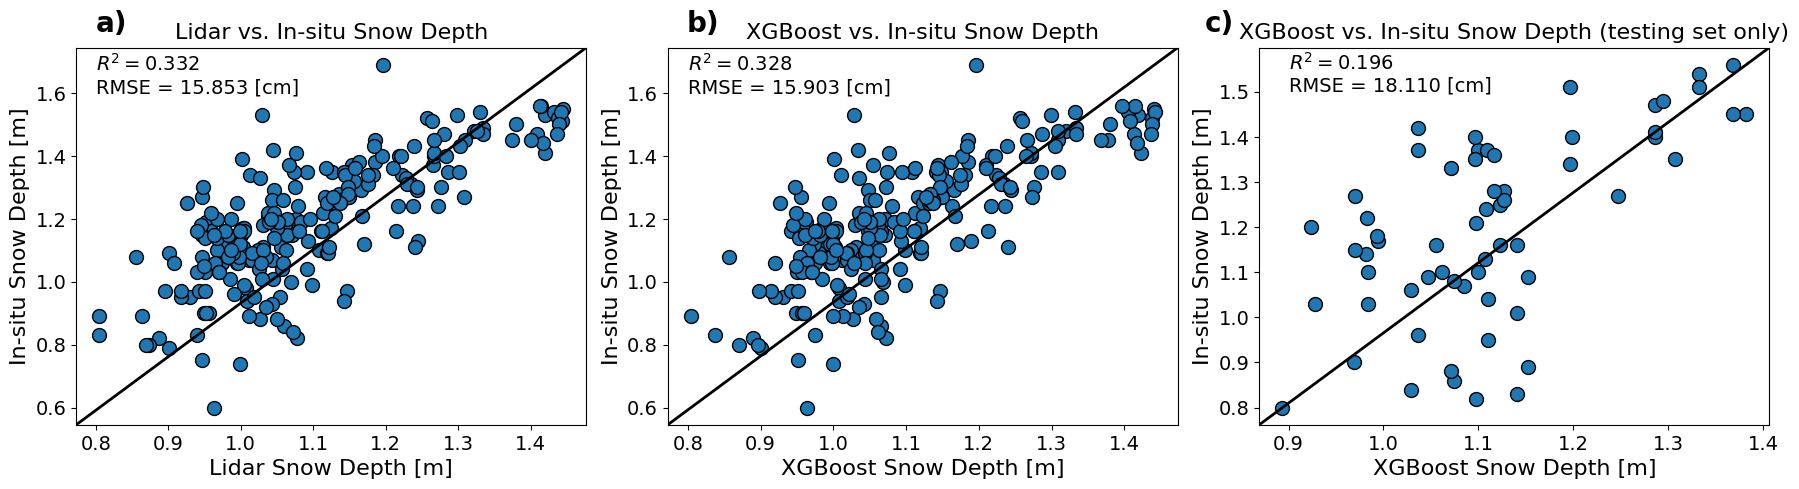

In [23]:
# Prepare the figure
plt.figure(figsize=(18, 5))

# Subplot 1
ax1 = plt.subplot(1, 3, 1)
plot_results(ax1, insitu_vs_lidar['snow_depth'], insitu_vs_lidar['observed_snow_depth'],
             'Lidar vs. In-situ Snow Depth', 'Lidar Snow Depth [m]', 'In-situ Snow Depth [m]', lidar_insitu_r2, lidar_insitu_rmse)
ax1.text(0.1, 1.1, 'a)', transform=ax1.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

# Subplot 2
ax2 = plt.subplot(1, 3, 2)
plot_results(ax2, insitu_vs_xgboost['snow_depth_pred'], insitu_vs_xgboost['observed_snow_depth'],
             'XGBoost vs. In-situ Snow Depth', 'XGBoost Snow Depth [m]', 'In-situ Snow Depth [m]', xgboost_insitu_r2, xgboost_insitu_rmse)
ax2.text(0.1, 1.1, 'b)', transform=ax2.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

# Subplot 3
ax3 = plt.subplot(1, 3, 3)
plot_results(ax3, insitu_vs_xgboost_test['snow_depth_pred'], insitu_vs_xgboost_test['observed_snow_depth'],
             'XGBoost vs. In-situ Snow Depth (testing set only)', 'XGBoost Snow Depth [m]', 'In-situ Snow Depth [m]', xgboost_test_insitu_r2, xgboost_test_insitu_rmse, pos1=0.90, pos2=1.5)
ax3.text(-0.05, 1.1, 'c)', transform=ax3.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.savefig('../plots/validation_plots.png', dpi=300)
plt.show()

## Spatial plots

In [71]:
null_values_df=(
    pd.read_csv('../data/nulls_only.csv')
    .assign(snow_depth_pred=lambda x: x.snow_depth)
)

full_data=(
    pd.concat([xgboost_pred, null_values_df], axis=0)
    .reset_index(drop=True)
    .sort_values(by='idx')
    .assign(snow_depth_diff=lambda x: x.snow_depth - x.snow_depth_pred)
)

In [72]:
shape=(2333, 3333)
true_depth=full_data.snow_depth.values.reshape(shape)
predicted_depth=full_data.snow_depth_pred.values.reshape(shape)
depth_error=full_data.snow_depth_diff.values.reshape(shape)

In [117]:
insitu_data_full = pd.read_csv('../data/all_insitu.csv')
new_insitu = insitu_data[insitu_data.northing.between(full_data.northing.min(), full_data.northing.max()) & insitu_data.easting.between(full_data.easting.min(), full_data.easting.max())]
new_insitu_full = insitu_data_full[insitu_data_full.northing.between(full_data.northing.min(), full_data.northing.max()) & insitu_data_full.easting.between(full_data.easting.min(), full_data.easting.max())]
new_insitu=new_insitu.sample(150)
new_insitu_full=new_insitu_full.sample(500)

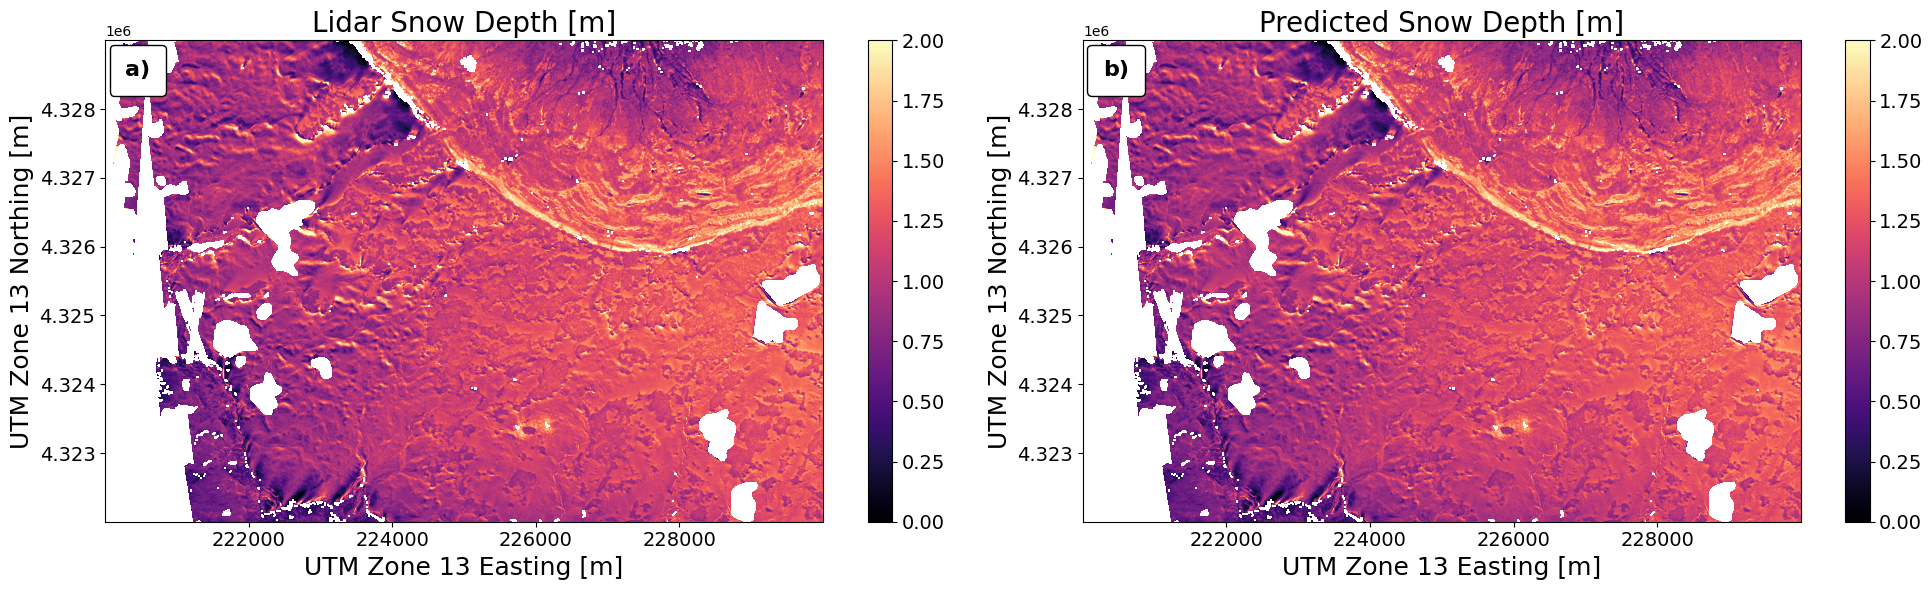

In [122]:
plt.figure(figsize=(20,6))
ax1=plt.subplot(1,2,1)

plot_var(
    variable=true_depth, 
    var_name='Lidar Snow Depth [m]', 
    clims=(0, 2), 
    pi_cbar=False, 
    easting=full_data.easting, 
    northing=full_data.northing,
    cmap='magma'
)
at = AnchoredText(chr(96 + 1) + ')', prop=dict(size=16, weight='bold'), frameon=True, loc='upper left')
at.patch.set_boxstyle("round,pad=0.3,rounding_size=0.2")
ax1.add_artist(at)


ax2=plt.subplot(1,2,2)

plot_var(
    variable=predicted_depth, 
    var_name='Predicted Snow Depth [m]', 
    clims=(0, 2), 
    pi_cbar=False, 
    easting=full_data.easting, 
    northing=full_data.northing,
    cmap='magma'
)
at = AnchoredText(chr(96 + 2) + ')', prop=dict(size=16, weight='bold'), frameon=True, loc='upper left')
at.patch.set_boxstyle("round,pad=0.3,rounding_size=0.2")
ax2.add_artist(at)
plt.tight_layout()

plt.savefig('../plots/predicted_depth_without_insitu.png', dpi=300)
plt.show()

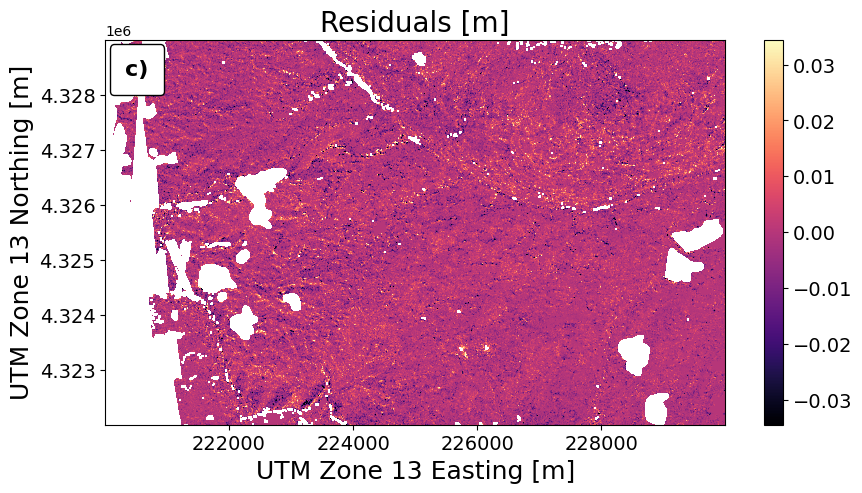

In [123]:
stdev=full_data.snow_depth_diff.std()
avg=full_data.snow_depth_diff.mean()

moe1 = avg - 1*stdev

moe2 = avg + 1*stdev
plt.figure(figsize=(10,5))
ax=plt.subplot(1,1,1)
plot_var(
    variable=depth_error, 
    var_name='Residuals [m]', 
    clims=(moe1, moe2), 
    pi_cbar=False, 
    easting=full_data.easting, 
    northing=full_data.northing,
    cmap='magma'
)
at = AnchoredText(chr(96 + 3) + ')', prop=dict(size=16, weight='bold'), frameon=True, loc='upper left')
at.patch.set_boxstyle("round,pad=0.3,rounding_size=0.2")
ax.add_artist(at)
plt.savefig('../plots/spatial_residual.png', dpi=300)
plt.show()